In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from math import sqrt, fabs, log
import pandas as pd
import SimTools



Welcome to JupyROOT 6.18/00


# Plot angular resolution versus fit length for specified Gas / Energy

In [2]:
#Load simulated electon angular resolution dat
df = pd.read_pickle("./MS_diff_testing_data.pk")

# here we impose sigma < 18 deg
# The 15 degree small angle is only meant for the MS treatment
df_test = df.loc[df.sigma < 18.0].reset_index(drop=True)
df_test.head()


,gas,energy,fit_length,ang_dist,sigma,sigma_err
0,he_co2,40,0.3,"[0.09565008108864512, 0.019966152443957632, 0....",17.290324,0.439907
1,he_co2,40,0.4,"[-0.02246158029892831, 0.055917632933756546, 0...",16.736018,0.422247
2,he_co2,50,0.3,"[0.2717915705146363, -0.007327414557466363, -0...",14.137019,0.360731
3,he_co2,50,0.4,"[0.24759604896089454, -0.06393891271361678, 0....",12.944192,0.307977
4,he_co2,50,0.5,"[0.30393779244236435, -0.13034005472204843, 0....",13.806869,0.331136


In [3]:
# Load dNDx data
df_dNdx = pd.read_pickle("dNdx_data.pk")
df_dNdx.head()

,gas,energy,dNdx,dNdx_err,energy_loss
0,he_co2,30,55.256648,0.191932,0.972517
1,he_co2,40,39.943510,0.163184,0.703006
2,he_co2,50,30.810596,0.143319,0.542266
3,he_co2,60,26.391711,0.132644,0.464494
4,he_co2,70,22.472663,0.122400,0.395519


In [4]:
# Select Gas
mixture = SimTools.he_co2

# Select Energy [keV]
Energy = 50 

# Select range of fit lengths to plot [cm]
fit_len_min = 0.2
fit_len_max = 0.9

In [5]:
# Select drift length [cm], our test cases are 25 cm for He:CF4 and 10 cm for He:CO2
if mixture["name"] == 'he_co2':
    drift = 10.0
elif mixture["name"] == 'he_cf4':
    drift = 25.0
else:
    print("Error: select valid gas mixture")

# Get Rossi fit parameter
S_2 = SimTools.rossi_fit_params["S_2"]
# Get uncertainty on Rossi fit parameter
S_2_sigma = SimTools.S2_std

# Get dNdx value [1/cm]
dNdx = df_dNdx.loc[ (df_dNdx.gas == mixture["name"]) & (df_dNdx.energy == Energy) ]['dNdx'].item()

# Get Radiation Length [m]
Rad_L = SimTools.Rad_Lengths[mixture["name"]]

# Get sigma for diffusion
if ('overide_sigma' in list(mixture)):
    sigma =  mixture['overide_sigma']
else:
    sigma_r = mixture['sigma_r']
    sigma_T = mixture['sigma_T']
    sigma = sqrt( sigma_r**2 + (sqrt(drift) * sigma_T )**2 )


# Find analytical extimation of the optimal fit length [m]
opt_L = SimTools.Opt_len( (Energy/1000.0, Rad_L), S_2, sigma, dNdx)

# Make selection on simulation data
df_cut=df_test.loc[ (df_test.gas==mixture["name"]) & (df_test.energy==Energy )  ].reset_index(drop=True)
df_cut

,gas,energy,fit_length,ang_dist,sigma,sigma_err
0,he_co2,50,0.3,"[0.2717915705146363, -0.007327414557466363, -0...",14.137019,0.360731
1,he_co2,50,0.4,"[0.24759604896089454, -0.06393891271361678, 0....",12.944192,0.307977
2,he_co2,50,0.5,"[0.30393779244236435, -0.13034005472204843, 0....",13.806869,0.331136
3,he_co2,50,0.6,"[0.36385801972770754, -0.18848054918507107, -0...",15.113326,0.367016
4,he_co2,50,0.7,"[0.35353248592703934, -0.2329480600215115, -0....",16.957131,0.405483


In [6]:
x_vals = np.arange(fit_len_min,fit_len_max,0.0001)

MS_contrib = []
MS_contrib_H = []
MS_contrib_L = []
PR_contrib = []

for x_val in x_vals:

    MS_contrib += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2) ]
    MS_contrib_H += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2+S_2_sigma) ]
    MS_contrib_L += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2-S_2_sigma) ]

    PR_contrib += [ SimTools.Point_Res(x_val/100.0, dNdx, sigma) ]


MS_contrib = np.array(MS_contrib)
MS_contrib_H = np.array(MS_contrib_H)
MS_contrib_L = np.array(MS_contrib_L)
PR_contrib = np.array(PR_contrib)


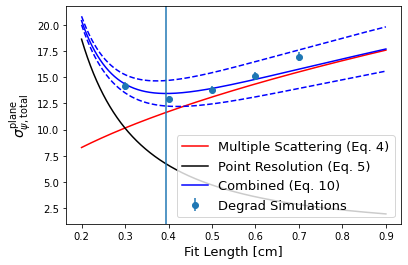

In [7]:
# Plot Simulation data
plt.errorbar(df_cut.fit_length , df_cut.sigma, yerr=df_cut.sigma_err, fmt='o',  label='Degrad Simulations')

# Plot MS and PR contributions
plt.plot(x_vals, MS_contrib, 'r-', label='Multiple Scattering (Eq. 4)')
plt.plot(x_vals, PR_contrib, 'k-', label='Point Resolution (Eq. 5)')

# Plot total point resolution with uncertainty on S_2
plt.plot(x_vals, np.sqrt(MS_contrib**2+PR_contrib**2), 'b-', label='Combined (Eq. 10)')
plt.plot(x_vals, np.sqrt(MS_contrib_H**2+PR_contrib**2), 'b--')
plt.plot(x_vals, np.sqrt(MS_contrib_L**2+PR_contrib**2), 'b--')

# Plot predicted optimal fit length
plt.axvline(opt_L*100)


plt.legend(loc="lower right", fontsize = 13)
plt.xlabel("Fit Length [cm]", fontsize = 13)
plt.ylabel("$ \sigma^{\\rm plane}_{\psi, \\rm{total} } $", fontsize = 14)
plt.savefig("../figures/sigma_vs_x.pdf")



# Plot best predicted vs best Simulated angular resolution for all test gases / energies

In [9]:
# Get Rossi fit parameter
S_2 = SimTools.rossi_fit_params["S_2"]
# Get uncertainty on Rossi fit parameter
S_2_sigma = SimTools.S2_std

# Function returning the point resolution given a gas mixture name
def get_sigma_x(gas_name):

    if gas_name == 'he_co2':
        drift = 10.0
        mixture = SimTools.he_co2

    elif gas_name == 'he_cf4':
        drift = 25.0
        mixture = SimTools.he_cf4
    else:
        print("Error: select valid gas mixture")

    # Get sigma for diffusion
    if ('overide_sigma' in list(mixture)):
        sigma =  mixture['overide_sigma']
    else:
        sigma_r = mixture['sigma_r']
        sigma_T = mixture['sigma_T']
        sigma = sqrt( sigma_r**2 + (sqrt(drift) * sigma_T )**2 )

    return sigma 



In [10]:
#Load simulated electon angular resolution data that has higher segmentation in x
df = pd.read_pickle("./MS_diff_testing_data_fine.pk")

# Keep only the energy range of interest for both gases
df_test2 = df.loc[ ((df.gas == 'he_co2') & (df.energy >= 50)) | ((df.gas == 'he_cf4') & (df.energy >= 70) ) ].reset_index(drop=True)
df_test2["fit_length"] = np.round(df_test2.fit_length,2)

In [11]:
# Group by gas and energy then find the index of the fit length with the smallest sigma
indices = np.array(df_test2.groupby(['gas','energy'])['sigma'].idxmin())

# Select rows corresponding to lowest sigma in each gas / energy group from original df
df_best_sim = df_test2.iloc[indices].reset_index(drop=True)

# add a column with the point resolution for each gas mixture
df_best_sim['sigma_x']=df_best_sim.gas.apply(get_sigma_x)

# Add column with optimal fit length [m]
df_best_sim['x_o'] = df_best_sim.apply(lambda row: SimTools.Opt_len( (row.energy/1000.0, SimTools.Rad_Lengths[row.gas]), S_2, row.sigma_x, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item()) , axis = 1)

# Add a column with the predict best angular resolution
df_best_sim['sigma_pred'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)
df_best_sim['sigma_pred_err_H'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2+S_2_sigma)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)
df_best_sim['sigma_pred_err_L'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2-S_2_sigma)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)

# Get the simulated angular resolution at x_o
df_best_sim['sigma_xo'] = df_best_sim.apply(lambda row: df_test2.loc[ (df_test2.gas == row.gas) & (df_test2.energy == row.energy ) & (df_test2.fit_length == round(row.x_o*100,2))  ].sigma.item()  , axis = 1)
df_best_sim['sigma_xo_err'] = df_best_sim.apply(lambda row: df_test2.loc[ (df_test2.gas == row.gas) & (df_test2.energy == row.energy ) & (df_test2.fit_length == round(row.x_o*100,2))  ].sigma_err.item()  , axis = 1)


df_best_sim


,gas,energy,fit_length,ang_dist,sigma,sigma_err,sigma_x,x_o,sigma_pred,sigma_pred_err_H,sigma_pred_err_L,sigma_xo,sigma_xo_err
0,he_cf4,70,0.46,"[0.27396465495665245, 0.39479643427211314, 0.0...",16.973045,0.434553,689.643637,0.003970,16.270347,17.765753,14.819851,17.100913,0.420875
1,he_cf4,80,0.47,"[0.1745519343414008, 0.011478393984056062, 0.2...",15.175132,0.386836,689.643637,0.004392,15.093691,16.480950,13.748093,15.427843,0.387511
2,he_cf4,90,0.44,"[0.15724795436965083, -0.2611975395539248, 0.0...",13.377415,0.326225,689.643637,0.004772,14.093653,15.388998,12.837208,13.773857,0.344160
3,he_cf4,100,0.52,"[0.014212899704359815, -0.36993673254938136, -...",13.135779,0.317189,689.643637,0.005146,13.271155,14.490906,12.088036,13.547266,0.336507
4,he_cf4,110,0.52,"[0.027310749982842334, -0.22630169835257807, 0...",11.531738,0.285173,689.643637,0.005506,12.571535,13.726983,11.450786,11.936283,0.295348
5,he_cf4,120,0.52,"[0.15448964824819936, 0.10244902411214965, -0....",10.658035,0.262885,689.643637,0.005781,11.893962,12.987134,10.833619,11.133284,0.283119
6,he_cf4,130,0.62,"[0.13742785924296977, -0.5976101377070058, -0....",10.555398,0.257256,689.643637,0.006115,11.370409,12.415462,10.356741,10.737502,0.271474
7,he_cf4,140,0.50,"[0.2790622186414922, 0.01042470551347107, -0.0...",10.043325,0.254821,689.643637,0.006430,10.901638,11.903606,9.929760,10.452330,0.257683
8,he_cf4,150,0.65,"[0.07541532256712451, -0.11726348049305736, -0...",9.344991,0.229629,689.643637,0.006744,10.489795,11.453911,9.554633,9.691802,0.243435
9,he_cf4,160,0.59,"[0.3059992156128739, -0.0691733124262826, 0.10...",8.607300,0.208678,689.643637,0.006969,10.062665,10.987523,9.165581,8.994993,0.215182


(45.0, 200.0)

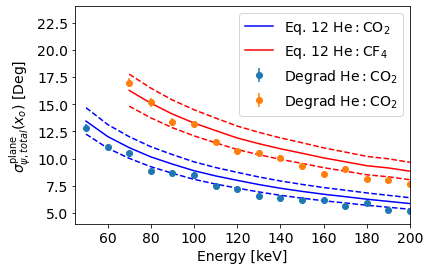

In [31]:
# Make Plot the best simulated sigma 
# this method has bias, selects data points with uncertainty below true ang res


# Plot He:CO2 result
df_he_co2 = df_best_sim.loc[df_best_sim.gas == "he_co2"]


plt.errorbar(df_he_co2.energy, df_he_co2.sigma, yerr=df_he_co2.sigma_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred,'b-',label='Eq. 12 $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_H,'b--')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_L,'b--')


# Plot He:CF4 result
df_he_cf4 = df_best_sim.loc[df_best_sim.gas == "he_cf4"]

plt.errorbar(df_he_cf4.energy, df_he_cf4.sigma, yerr=df_he_cf4.sigma_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred,'r-',label='Eq. 12 $ { \\rm He} : {\\rm CF}_4$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_H,'r--')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_L,'r--')


plt.legend(loc='upper right',fontsize=14)

plt.xlabel("Energy [keV]",fontsize=14)
plt.ylabel("$\\sigma_{\\psi , total}^{\\rm plane} (x_o)$ [Deg]",fontsize=14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylim(4,24)
plt.xlim(45,200)



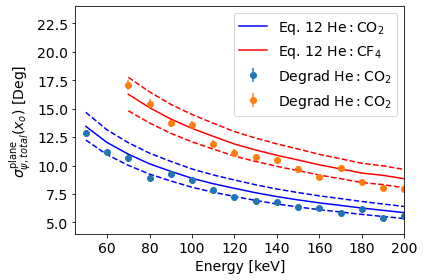

In [30]:
# Plot the simulated sigma at x_o


# Plot He:CO2 result
df_he_co2 = df_best_sim.loc[df_best_sim.gas == "he_co2"]


plt.errorbar(df_he_co2.energy, df_he_co2.sigma_xo, yerr=df_he_co2.sigma_xo_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred,'b-',label='Eq. 12 $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_H,'b--')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_L,'b--')


# Plot He:CF4 result
df_he_cf4 = df_best_sim.loc[df_best_sim.gas == "he_cf4"]

plt.errorbar(df_he_cf4.energy, df_he_cf4.sigma_xo, yerr=df_he_cf4.sigma_xo_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred,'r-',label='Eq. 12 $ { \\rm He} : {\\rm CF}_4$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_H,'r--')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_L,'r--')


plt.legend(loc='upper right',fontsize=14)

plt.xlabel("Energy [keV]",fontsize=14)
plt.ylabel("$\\sigma_{\\psi , total}^{\\rm plane} (x_o)$ [Deg]",fontsize=14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylim(4,24)
plt.xlim(45,200)
plt.tight_layout()
plt.savefig("../figures/best_ang_res.pdf")



In [38]:
print("Mean residual [Deg.]: ", np.mean(np.abs((df_best_sim.sigma_xo - df_best_sim.sigma_pred))))

Mean residual [Deg.]:  0.5894105303691276
